In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import collections
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import HuberRegressor

# STARTER NOTEBOOK

In [2]:
train_df = pd.read_csv('../input/tourism/tourism_train.csv')
test_df = pd.read_csv('../input/tourism/tourism_test.csv')
data=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)
data.columns.tolist()

['ID',
 'country',
 'age_group',
 'travel_with',
 'total_female',
 'total_male',
 'purpose',
 'main_activity',
 'info_source',
 'tour_arrangement',
 'package_transport_int',
 'package_accomodation',
 'package_food',
 'package_transport_tz',
 'package_sightseeing',
 'package_guided_tour',
 'package_insurance',
 'night_mainland',
 'night_zanzibar',
 'payment_mode',
 'first_trip_tz',
 'most_impressing',
 'total_cost']

In [3]:
len(test_df)

1601

In [4]:
data.travel_with.fillna('None',inplace=True)
data.most_impressing.fillna('None',inplace=True)
data.total_female.fillna(data.total_female.mean(),inplace = True)
data.total_male.fillna(data.total_male.mean(),inplace = True)

In [5]:
le = LabelEncoder()
data['age_group'] = le.fit_transform(data['age_group'])
data['package_transport_int'] = le.fit_transform(data['package_transport_int'])
data['package_accomodation'] = le.fit_transform(data['package_accomodation'])
data['package_food'] = le.fit_transform(data['package_food'])
data['package_transport_tz'] = le.fit_transform(data['package_transport_tz'])
data['package_sightseeing'] = le.fit_transform(data['package_sightseeing'])
data['package_guided_tour'] = le.fit_transform(data['package_guided_tour'])
data['package_insurance'] = le.fit_transform(data['package_insurance'])
data['first_trip_tz'] = le.fit_transform(data['first_trip_tz'])
data['country'] = le.fit_transform(data['country'])

In [6]:
columns_to_transform = ['tour_arrangement','travel_with','purpose','main_activity','info_source','most_impressing','payment_mode']
data = pd.get_dummies( data,columns = columns_to_transform,drop_first=True)

In [7]:
data["total_female"] = data['total_female'].astype('int')
data["total_male"] = data['total_male'].astype('int')
data["night_mainland"] = data['night_mainland'].astype('int')
data["night_zanzibar"] = data['night_zanzibar'].astype('int')
#feature engineering
data["total_persons"] = data["total_female"] + data["total_male"]

data["total_nights_spent"] = data["night_mainland"] + data["night_zanzibar"]

data = data.loc[(data['total_persons'] <= 20)]
data = data.loc[(data['total_nights_spent'] <= 200)]

In [8]:
## separate data into train and test
train_df=data[data.total_cost.notnull()].reset_index(drop=True)
test_df=data[data.total_cost.isna()].reset_index(drop=True)

In [9]:
#Modelling
feat_cols = train_df.drop(["ID","total_cost"],1)
cols = feat_cols.columns
target=train_df["total_cost"]

In [10]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(train_df[cols],target, test_size=0.25, random_state = 42)

In [11]:
xgb=xgb.XGBRegressor( n_estimators= 200,learning_rate = 0.05,max_depth =5)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [12]:
mae = mean_absolute_error(y_test, y_pred)
print('Error {}'.format(mae))

Error 5093275.928263184


In [13]:
#predict and prepare submission file
sub = test_df[cols]
predictions_xgb  = xgb.predict(sub)
submission_df = pd.DataFrame({'ID': test_df.ID, 'total_cost': predictions_xgb})
submission_df.to_csv('submission10.csv',index=False)

In [14]:
#random forest
rfr_reg = RandomForestRegressor(max_depth= 10, max_features=53, n_estimators= 300)
rfr_reg.fit(X_train, y_train)
rfr_pred = rfr_reg.predict(X_test)
mae_rfr = mean_absolute_error(y_test, rfr_pred)
print('RandomForestError {}'.format(mae_rfr))

RandomForestError 5063743.808387492


In [15]:
sub = test_df[cols]
predictions_rfr  = rfr_reg.predict(sub)
submission_df = pd.DataFrame({'ID': test_df.ID, 'total_cost': predictions_rfr})
submission_df.to_csv('submission11.csv',index=False)

In [16]:
#Extratree Regressor
#'ExtraTreesRegressor': { 'n_estimators': [16, 32] }
catboost = CatBoostRegressor()
catboost.fit(X_train, y_train)
cat_preds = catboost.predict(X_test)
mae_cat = mean_absolute_error(y_test, cat_preds)
print('CATBoost Error: {}'.format(mae_cat))

Learning rate set to 0.04904
0:	learn: 12098412.4162277	total: 55.7ms	remaining: 55.7s
1:	learn: 11909788.8442404	total: 59.5ms	remaining: 29.7s
2:	learn: 11748797.6979490	total: 62.7ms	remaining: 20.8s
3:	learn: 11595356.8187079	total: 66.3ms	remaining: 16.5s
4:	learn: 11454273.5628170	total: 68.2ms	remaining: 13.6s
5:	learn: 11326413.7367286	total: 70.1ms	remaining: 11.6s
6:	learn: 11191763.0802142	total: 72.4ms	remaining: 10.3s
7:	learn: 11081168.1070998	total: 74.3ms	remaining: 9.21s
8:	learn: 10973621.3614054	total: 76.2ms	remaining: 8.39s
9:	learn: 10868692.3540584	total: 78.1ms	remaining: 7.73s
10:	learn: 10777686.8492781	total: 80.1ms	remaining: 7.2s
11:	learn: 10680736.0590261	total: 82.7ms	remaining: 6.81s
12:	learn: 10593313.9993864	total: 84.8ms	remaining: 6.44s
13:	learn: 10516918.2486924	total: 86.9ms	remaining: 6.12s
14:	learn: 10434377.7244501	total: 89.2ms	remaining: 5.86s
15:	learn: 10367027.5045564	total: 92.4ms	remaining: 5.68s
16:	learn: 10292849.0252496	total: 95.

161:	learn: 8293367.8294788	total: 435ms	remaining: 2.25s
162:	learn: 8289602.7959157	total: 438ms	remaining: 2.25s
163:	learn: 8277406.5951409	total: 440ms	remaining: 2.24s
164:	learn: 8272784.8312617	total: 442ms	remaining: 2.24s
165:	learn: 8261434.5226423	total: 444ms	remaining: 2.23s
166:	learn: 8256319.8325346	total: 446ms	remaining: 2.22s
167:	learn: 8249385.8383988	total: 448ms	remaining: 2.22s
168:	learn: 8248338.5897133	total: 450ms	remaining: 2.21s
169:	learn: 8245423.2540425	total: 452ms	remaining: 2.21s
170:	learn: 8241055.8065771	total: 454ms	remaining: 2.2s
171:	learn: 8230896.3260155	total: 456ms	remaining: 2.19s
172:	learn: 8220540.1607497	total: 458ms	remaining: 2.19s
173:	learn: 8215359.5302776	total: 460ms	remaining: 2.18s
174:	learn: 8209785.9424318	total: 462ms	remaining: 2.18s
175:	learn: 8205997.5800109	total: 464ms	remaining: 2.17s
176:	learn: 8194317.6635339	total: 466ms	remaining: 2.17s
177:	learn: 8191635.2426616	total: 468ms	remaining: 2.16s
178:	learn: 818

317:	learn: 7516708.8630409	total: 759ms	remaining: 1.63s
318:	learn: 7512532.9356293	total: 763ms	remaining: 1.63s
319:	learn: 7508885.3538617	total: 765ms	remaining: 1.62s
320:	learn: 7506902.9903803	total: 767ms	remaining: 1.62s
321:	learn: 7504841.0261322	total: 769ms	remaining: 1.62s
322:	learn: 7494712.2283619	total: 771ms	remaining: 1.61s
323:	learn: 7491831.3850387	total: 773ms	remaining: 1.61s
324:	learn: 7482646.5328155	total: 775ms	remaining: 1.61s
325:	learn: 7480170.6569281	total: 778ms	remaining: 1.61s
326:	learn: 7477983.4759112	total: 779ms	remaining: 1.6s
327:	learn: 7476252.3911992	total: 781ms	remaining: 1.6s
328:	learn: 7470617.1256906	total: 783ms	remaining: 1.6s
329:	learn: 7469344.0186444	total: 785ms	remaining: 1.59s
330:	learn: 7464305.8827535	total: 787ms	remaining: 1.59s
331:	learn: 7460756.4856689	total: 789ms	remaining: 1.59s
332:	learn: 7453622.7896146	total: 791ms	remaining: 1.58s
333:	learn: 7447908.2272470	total: 793ms	remaining: 1.58s
334:	learn: 74468

500:	learn: 6744180.0470583	total: 1.14s	remaining: 1.13s
501:	learn: 6739179.0325397	total: 1.14s	remaining: 1.13s
502:	learn: 6737154.5715205	total: 1.14s	remaining: 1.13s
503:	learn: 6734417.8310188	total: 1.14s	remaining: 1.13s
504:	learn: 6730890.4206920	total: 1.15s	remaining: 1.12s
505:	learn: 6726407.9489673	total: 1.15s	remaining: 1.12s
506:	learn: 6724453.2049080	total: 1.15s	remaining: 1.12s
507:	learn: 6722561.3382784	total: 1.15s	remaining: 1.12s
508:	learn: 6720729.5704737	total: 1.16s	remaining: 1.11s
509:	learn: 6718955.2970852	total: 1.16s	remaining: 1.11s
510:	learn: 6717236.0743558	total: 1.16s	remaining: 1.11s
511:	learn: 6715569.6067841	total: 1.16s	remaining: 1.11s
512:	learn: 6713893.4465674	total: 1.16s	remaining: 1.1s
513:	learn: 6706259.4361938	total: 1.17s	remaining: 1.1s
514:	learn: 6704686.3727546	total: 1.17s	remaining: 1.1s
515:	learn: 6703160.4362360	total: 1.17s	remaining: 1.1s
516:	learn: 6701679.7771515	total: 1.17s	remaining: 1.09s
517:	learn: 670018

650:	learn: 6318012.0630375	total: 1.52s	remaining: 814ms
651:	learn: 6313959.3482237	total: 1.52s	remaining: 812ms
652:	learn: 6311253.5568529	total: 1.52s	remaining: 809ms
653:	learn: 6309745.7961239	total: 1.52s	remaining: 807ms
654:	learn: 6305708.5076303	total: 1.53s	remaining: 804ms
655:	learn: 6301705.4752301	total: 1.53s	remaining: 802ms
656:	learn: 6298457.2682887	total: 1.53s	remaining: 800ms
657:	learn: 6294654.0437879	total: 1.53s	remaining: 797ms
658:	learn: 6289233.4869661	total: 1.53s	remaining: 795ms
659:	learn: 6285220.7922636	total: 1.54s	remaining: 792ms
660:	learn: 6281594.1866169	total: 1.54s	remaining: 790ms
661:	learn: 6276518.2042467	total: 1.54s	remaining: 787ms
662:	learn: 6273392.0021498	total: 1.54s	remaining: 785ms
663:	learn: 6267284.5823483	total: 1.54s	remaining: 782ms
664:	learn: 6263839.3518789	total: 1.55s	remaining: 780ms
665:	learn: 6263229.8196944	total: 1.55s	remaining: 777ms
666:	learn: 6260624.0606634	total: 1.55s	remaining: 775ms
667:	learn: 62

809:	learn: 5839379.8817647	total: 1.9s	remaining: 445ms
810:	learn: 5836313.4099399	total: 1.9s	remaining: 443ms
811:	learn: 5833955.7378904	total: 1.9s	remaining: 441ms
812:	learn: 5831996.7337399	total: 1.91s	remaining: 439ms
813:	learn: 5828771.5654396	total: 1.91s	remaining: 436ms
814:	learn: 5825872.9163782	total: 1.91s	remaining: 434ms
815:	learn: 5821929.5140272	total: 1.92s	remaining: 432ms
816:	learn: 5818870.5973152	total: 1.92s	remaining: 430ms
817:	learn: 5816502.6281755	total: 1.92s	remaining: 427ms
818:	learn: 5814309.9313358	total: 1.92s	remaining: 425ms
819:	learn: 5812147.7788267	total: 1.92s	remaining: 422ms
820:	learn: 5810852.3835608	total: 1.93s	remaining: 420ms
821:	learn: 5806014.4308932	total: 1.93s	remaining: 418ms
822:	learn: 5804820.5500917	total: 1.93s	remaining: 415ms
823:	learn: 5804013.0873590	total: 1.93s	remaining: 413ms
824:	learn: 5801113.2195940	total: 1.93s	remaining: 410ms
825:	learn: 5798657.0463097	total: 1.94s	remaining: 408ms
826:	learn: 57945

968:	learn: 5474952.8616207	total: 2.29s	remaining: 73.2ms
969:	learn: 5472042.8670343	total: 2.29s	remaining: 70.9ms
970:	learn: 5469156.8834185	total: 2.3s	remaining: 68.6ms
971:	learn: 5467623.1037229	total: 2.3s	remaining: 66.3ms
972:	learn: 5466202.4521972	total: 2.3s	remaining: 64ms
973:	learn: 5462952.0969920	total: 2.31s	remaining: 61.6ms
974:	learn: 5461093.1903765	total: 2.31s	remaining: 59.2ms
975:	learn: 5459832.4570744	total: 2.31s	remaining: 56.9ms
976:	learn: 5458655.8355990	total: 2.32s	remaining: 54.5ms
977:	learn: 5457353.7804808	total: 2.32s	remaining: 52.2ms
978:	learn: 5455787.3086323	total: 2.32s	remaining: 49.8ms
979:	learn: 5454550.7787755	total: 2.33s	remaining: 47.5ms
980:	learn: 5453149.0324833	total: 2.33s	remaining: 45.1ms
981:	learn: 5450743.3331652	total: 2.33s	remaining: 42.8ms
982:	learn: 5449843.8915246	total: 2.34s	remaining: 40.5ms
983:	learn: 5446450.1821509	total: 2.34s	remaining: 38.1ms
984:	learn: 5445269.4577841	total: 2.35s	remaining: 35.8ms
98

In [17]:
sub = test_df[cols]
predictions_cat  = catboost.predict(sub)
submission_df = pd.DataFrame({'ID': test_df.ID, 'total_cost': predictions_cat})
submission_df.to_csv('submission12.csv',index=False)

In [18]:
#Orthogonal Matching Pursuit
omp = OrthogonalMatchingPursuit()
omp.fit(X_train, y_train)
omp_preds = omp.predict(X_test)
omp_mae = mean_absolute_error(y_test, omp_preds)
print('OMP MAE {}'.format(omp_mae))

OMP MAE 5782055.831919736


In [19]:
sub = test_df[cols]
predictions_omp  = omp.predict(sub)
submission_df = pd.DataFrame({'ID': test_df.ID, 'total_cost': predictions_omp})
submission_df.to_csv('submission13.csv',index=False)

# MY NOTEBOOK

In [23]:
train_df = pd.read_csv('../input/tourism/tourism_train.csv')
test_df = pd.read_csv('../input/tourism/tourism_test.csv')

In [24]:
#removing outliers in the data and creating new columns
train_df = train_df.loc[(train_df['night_zanzibar'] <= 30)]
train_df = train_df.loc[(train_df['night_mainland'] <= 70)]
train_df['total_individuals'] = train_df['total_female']+train_df['total_male']
test_df['total_individuals'] = test_df['total_female']+test_df['total_male']

In [25]:
#train_df = train_df.loc[(train_df['total_individuals'] <= 7)]

In [26]:
#grouping the countries in their respective continents
def set_value(row_number, assigned_value):
    return assigned_value[row_number]
country_dict = dict.fromkeys(['SWIZERLAND', 'MACEDONIA','UNITED KINGDOM','MALT',
                             'AUSTRIA','IRELAND', 'DENMARK', 'SPAIN', 'FRANCE','GERMANY',
                             'ITALY','SWEDEN','NETHERLANDS','BELGIUM', 'NORWAY', 
                             'BURGARIA','BULGARIA', 'GREECE','PORTUGAL','ISRAEL', 'FINLAND', 'CZECH REPUBLIC',
                              'UKRAIN','BOSNIA','SCOTLAND', 'RUSSIA','LUXEMBOURG', 'POLAND',
                             'LITHUANIA', 'HUNGARY','SLOVENIA','MONTENEGRO','SLOVAKIA', 'ROMANIA',
                             'LATVIA', 'CROATIA','SERBIA','GEORGIA','CYPRUS','ESTONIA'], 'Europe')
country_dict.update(dict.fromkeys(['SOUTH AFRICA', 'MOZAMBIQUE', 'MALAWI','ZIMBABWE', 'ZAMBIA', 
                                  'SWAZILAND','LESOTHO','ANGOLA', 'NAMIBIA', 'BOTSWANA' ], 'Southern_Africa'))
country_dict.update(dict.fromkeys(['NIGERIA','GUINEA', 'GHANA','LIBERIA', 'NIGER','CAPE VERDE','IVORY COAST' ], 'West_Africa'))
country_dict.update(dict.fromkeys(['RWANDA', 'KENYA', 'UGANDA', 'CONGO', 'DRC','MAURITIUS', 'BURUNDI', 
                                  'ETHIOPIA', 'SOMALI','COMORO', 'SUDAN', 'MADAGASCAR', 'DJIBOUT'], 'Eastern_Africa'))
country_dict.update(dict.fromkeys(['ALGERIA', 'EGYPT','TUNISIA','MORROCO'], 'North_Africa'))
country_dict.update(dict.fromkeys(['CHINA', 'INDIA', 'VIETNAM','MYANMAR','KOREA','MALAYSIA','PAKISTAN',
                                  'NEPAL','BANGLADESH', 'SINGAPORE', 'INDONESIA','TURKEY', 'SRI LANKA', 
                                  'TAIWAN', 'PHILIPINES', 'THAILAND','JAPAN'], 'Asia'))
country_dict.update(dict.fromkeys(['QATAR','SAUD ARABIA','UAE', 'YEMEN','OMAN','KUWAIT',
                                  'IRAQ','IRAN','UNITED ARAB EMIRATES', 'LEBANON'], 'Middle_East'))
country_dict.update(dict.fromkeys(['UNITED STATES OF AMERICA','DOMINICA', 'CANADA','HAITI', 'MEXICO', 'BERMUDA'], 'North_America'))
country_dict.update(dict.fromkeys(['BRAZIL','PERU','JAMAICA', 'COLOMBIA','TRINIDAD TOBACCO','COSTARICA','CHILE','ARGENTINA', 'URUGUAY'], 'South_Africa'))
country_dict.update(dict.fromkeys(['AUSTRALIA', 'NEW ZEALAND'], 'Oceania'))
train_df['Region_of_origin'] = train_df['country'].apply(set_value, args=(country_dict, ))
test_df['Region_of_origin'] = test_df['country'].apply(set_value, args=(country_dict, ))
train_df['Region_of_origin'].unique(), test_df['Region_of_origin'].unique()

(array(['Europe', 'Asia', 'Southern_Africa', 'North_America',
        'West_Africa', 'South_Africa', 'Eastern_Africa', 'North_Africa',
        'Middle_East', 'Oceania'], dtype=object),
 array(['Oceania', 'Southern_Africa', 'Europe', 'North_America', 'Asia',
        'Eastern_Africa', 'Middle_East', 'West_Africa', 'South_Africa',
        'North_Africa'], dtype=object))

In [27]:
#replacing nan values in the travel with column with appropriate values
cmap = {1.0:'Alone', (2.0,3.0,4.0,5.0,6.0,7.0): 'Friends/Relatives'}
train_df['travel_with'] = train_df['travel_with'].fillna(train_df['total_individuals'].map(cmap))
test_df['travel_with'] = test_df['travel_with'].fillna(test_df['total_individuals'].map(cmap))

In [28]:
train_df['most_impressing'] = train_df['most_impressing'].fillna(train_df['most_impressing'].mode()[0])
test_df['most_impressing'] = test_df['most_impressing'].fillna(test_df['most_impressing'].mode()[0])
test_df['travel_with'] = test_df['travel_with'].fillna(test_df['travel_with'].mode()[0])

In [29]:
train_df = train_df.dropna()
#test_df = test_df.dropna()

In [30]:
train_df['total_nights'] = train_df['night_zanzibar']+train_df['night_mainland']
test_df['total_nights'] = test_df['night_zanzibar']+test_df['night_mainland']

sc = StandardScaler()
tot_individuals = train_df['total_individuals']
zanzibar_nights = train_df['night_zanzibar']
zanzibar_nights = zanzibar_nights.values.reshape(-1,1)
mainland_nights = train_df['night_mainland']
mainland_nights = mainland_nights.values.reshape(-1,1)
tot_individuals = tot_individuals.values.reshape(-1,1)
tot_individuals = sc.fit_transform(tot_individuals)
zanzibar_nights = sc.fit_transform(zanzibar_nights)
mainland_nights = sc.fit_transform(mainland_nights)
train_df['total_individuals_scaled'] = tot_individuals
train_df['scaled_zanzibar'] = zanzibar_nights
train_df['scaled_mainland'] = mainland_nights


tot_individuals = test_df['total_individuals']
zanzibar_nights = test_df['night_zanzibar']
zanzibar_nights = zanzibar_nights.values.reshape(-1,1)
mainland_nights = test_df['night_mainland']
mainland_nights = mainland_nights.values.reshape(-1,1)
tot_individuals = tot_individuals.values.reshape(-1,1)
tot_individuals = sc.fit_transform(tot_individuals)
zanzibar_nights = sc.fit_transform(zanzibar_nights)
mainland_nights = sc.fit_transform(mainland_nights)
test_df['total_individuals_scaled'] = tot_individuals
test_df['scaled_zanzibar'] = zanzibar_nights
test_df['scaled_mainland'] = mainland_nights

In [31]:
train_df.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost', 'total_individuals', 'Region_of_origin', 'total_nights'],
      dtype='object')

In [32]:
#encoding the categorical columns
lb = LabelBinarizer()
#encoder_dict = collections.defaultdict(lb)
'''
train_cat = train_df.drop(columns=['ID','total_female','total_male',
                                  'night_mainland','night_zanzibar','total_cost',
                                   'total_individuals','total_individuals_scaled',
                                   'scaled_zanzibar', 'scaled_mainland'], axis=1)
#train_cat.columns
'''

"\ntrain_cat = train_df.drop(columns=['ID','total_female','total_male',\n                                  'night_mainland','night_zanzibar','total_cost',\n                                   'total_individuals','total_individuals_scaled',\n                                   'scaled_zanzibar', 'scaled_mainland'], axis=1)\n#train_cat.columns\n"

In [33]:
train_df['age_group'] = lb.fit_transform(train_df['age_group'])
train_df['travel_with'] = lb.fit_transform(train_df['travel_with'])
train_df['purpose'] = lb.fit_transform(train_df['purpose'])
train_df['main_activity'] = lb.fit_transform(train_df['main_activity'])
train_df['info_source'] = lb.fit_transform(train_df['info_source'])
train_df['tour_arrangement'] = lb.fit_transform(train_df['tour_arrangement'])
train_df['package_transport_int'] = lb.fit_transform(train_df['package_transport_int'])
train_df['package_accomodation'] = lb.fit_transform(train_df['package_accomodation'])
train_df['package_food'] = lb.fit_transform(train_df['package_food'])
train_df['package_transport_tz'] = lb.fit_transform(train_df['package_transport_tz'])
train_df['package_sightseeing'] = lb.fit_transform(train_df['package_sightseeing'])
train_df['package_guided_tour'] = lb.fit_transform(train_df['package_guided_tour'])
train_df['package_insurance'] = lb.fit_transform(train_cat['package_insurance'])
train_df['payment_mode'] = lb.fit_transform(train_df['payment_mode'])
train_df['first_trip_tz'] = lb.fit_transform(train_df['first_trip_tz'])
train_df['most_impressing'] = lb.fit_transform(train_df['most_impressing'])
#train_df['Region_of_origin'] = lb.fit_transform(train_df['Region_of_origin'])
train_df['country'] = lb.fit_transform(train_df['country'])

NameError: name 'train_cat' is not defined

In [34]:
test_df['age_group'] = lb.fit_transform(test_df['age_group'])
test_df['travel_with'] = lb.fit_transform(test_df['travel_with'])
test_df['purpose'] = lb.fit_transform(test_df['purpose'])
test_df['main_activity'] = lb.fit_transform(test_df['main_activity'])
test_df['info_source'] = lb.fit_transform(test_df['info_source'])
test_df['tour_arrangement'] = lb.fit_transform(test_df['tour_arrangement'])
test_df['package_transport_int'] = lb.fit_transform(test_df['package_transport_int'])
test_df['package_accomodation'] = lb.fit_transform(test_df['package_accomodation'])
test_df['package_food'] = lb.fit_transform(test_df['package_food'])
test_df['package_transport_tz'] = lb.fit_transform(test_df['package_transport_tz'])
test_df['package_sightseeing'] = lb.fit_transform(test_df['package_sightseeing'])
test_df['package_guided_tour'] = lb.fit_transform(test_df['package_guided_tour'])
test_df['package_insurance'] = lb.fit_transform(test_df['package_insurance'])
test_df['payment_mode'] = lb.fit_transform(test_df['payment_mode'])
test_df['first_trip_tz'] = lb.fit_transform(test_df['first_trip_tz'])
test_df['most_impressing'] = lb.fit_transform(test_df['most_impressing'])
#test_df['Region_of_origin'] = lb.fit_transform(test_df['Region_of_origin'])
test_df['country'] = lb.fit_transform(test_df['country'])

In [35]:
train_df.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'payment_mode', 'first_trip_tz', 'most_impressing',
       'total_cost', 'total_individuals', 'Region_of_origin', 'total_nights'],
      dtype='object')

In [36]:
#feature importance
pipe = Pipeline([('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

param_space = {'model__max_depth': [10, 15, 20],
               'model__max_features': [10, 15, 20],
               'model__n_estimators': [250, 300, 350]}

grid = GridSearchCV(pipe, param_grid=param_space, cv=10, scoring='neg_mean_absolute_error')

grid.fit(train_df.drop(columns=['ID', 'total_female','total_male','total_cost', 
                          'night_mainland','night_zanzibar'], axis=1), train_df['total_cost'])

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 304, in fit
    accept_sparse="csc", dtype=DTYPE)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/skle

ValueError: could not convert string to float: 'SWIZERLAND'

In [37]:
print('best-fit parameters:', grid.best_params_)
print('prediction rms residuals:', (-grid.best_score_))

best-fit parameters: {'model__max_depth': 10, 'model__max_features': 10, 'model__n_estimators': 250}
prediction rms residuals: nan


KeyError: "None of [Index(['total_individuals_scaled', 'scaled_zanzibar', 'scaled_mainland'], dtype='object')] are in the [columns]"

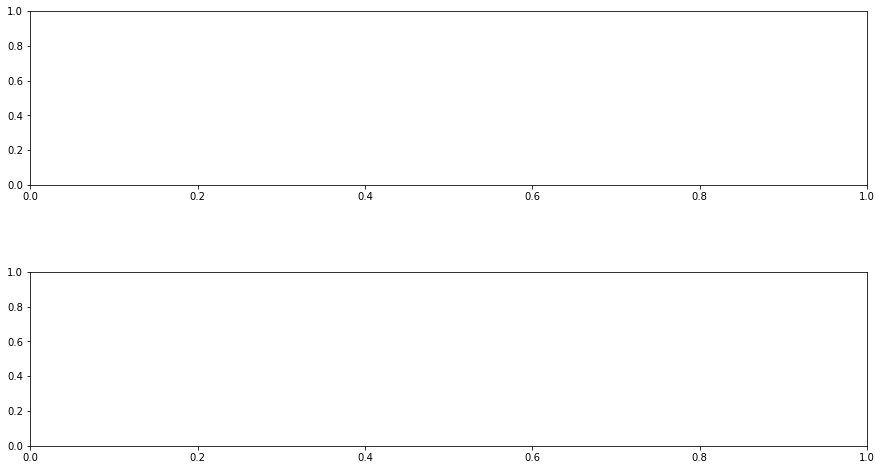

In [39]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharey=True)
plt.subplots_adjust(hspace=0.5)
#checking for correlation in the data
#continuous_data = ['total_individuals_scaled', 'scaled_zanzibar', 'scaled_mainland']
ordinal_data = ['age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance',
       'payment_mode', 'first_trip_tz', 'most_impressing','Region_of_origin']
train_df[continuous_data].corrwith(train_df['total_cost']).agg('square').plot.bar(ax=ax1, alpha=0.5)
ax1.set_title('Coefficient of Determination: Continuous Features')
ax1.grid()

# ordinal features
train_df[ordinal_data].corrwith(train_df['total_cost']).agg('square').plot.bar(ax=ax2, alpha=0.5)
ax2.set_title('Coefficient of Determination: Ordinal Features')
ax2.grid()

In [40]:
#identifying the top ten features
results = pd.DataFrame(train_df.drop('total_cost', axis=1).corrwith(train_df['total_cost']).agg('square'), 
                       columns=['det_weight'])

ranks = np.zeros(len(results), dtype=np.int)
for i, j in enumerate(np.argsort(results.det_weight)[::-1]):
    ranks[j] = i
results['det_rank'] = ranks

results.sort_values('det_rank').loc[:, ['det_rank', 'det_weight']].iloc[0:20]

,det_rank,det_weight
tour_arrangement,0,0.222427
package_accomodation,1,0.216558
package_food,2,0.190561
package_transport_tz,3,0.189128
package_transport_int,4,0.185745
package_sightseeing,5,0.157606
package_guided_tour,6,0.140670
travel_with,7,0.134500
total_female,8,0.080733
total_individuals,9,0.077215


feats = ['tour_arrangement', 'package_accomodation', 'package_food', 'package_transport_tz', 
        'package_transport_int', 'package_sightseeing', 'total_individuals_scaled', 'package_guided_tour', 
        'travel_with']
X = train_df[feats]
y = train_df['total_cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)





X = train_df.drop(columns=['ID', 'country','total_female','total_male','total_cost', 
                          'night_mainland','night_zanzibar','total_individuals'], axis=1)
test_data = test_df.drop(columns=['ID', 'country','total_female','total_male', 
                          'night_mainland','night_zanzibar','total_individuals'])
y = train_df['total_cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [43]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 10,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_
hyperParameterTuning(X_train, y_train)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s


KeyboardInterrupt: 

In [44]:
xgb_model = xgb.XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.5,
        learning_rate = 0.05,
        max_depth = 6,
        min_child_weight = 1,
        n_estimators = 1000,
        subsample = 0.7)

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("MAE: ", mae_xgb)

CPU times: user 1.15 s, sys: 17.3 ms, total: 1.17 s
Wall time: 316 ms
MAE:  4885537.849374273
